#MNIST

In [1]:
!pip install idx2numpy
!pip install scipy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=6089d674ff075c17bb2702f5774f5836b3093ff9dd700fccdb3d643fbe19eb34
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


In [2]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import pickle
from scipy.sparse import csr_matrix

Mounted at /content/drive


In [3]:
train_images_path = '/content/drive/MyDrive/USML/HW1/Prob_3/train-images.idx3-ubyte'
train_labels_path = '/content/drive/MyDrive/USML/HW1/Prob_3/train-labels.idx1-ubyte'
test_images_path = '/content/drive/MyDrive/USML/HW1/Prob_3/t10k-images.idx3-ubyte'
test_labels_path = '/content/drive/MyDrive/USML/HW1/Prob_3/t10k-labels.idx1-ubyte'

In [4]:
train_images = idx2numpy.convert_from_file(train_images_path)
train_labels = idx2numpy.convert_from_file(train_labels_path)
test_images = idx2numpy.convert_from_file(test_images_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)

In [5]:
# 1. Combine data to get 70k images
all_imgs = np.concatenate((train_images, test_images), axis=0)

In [6]:
all_imgs.shape

(70000, 28, 28)

In [7]:
# 2. Flat all images
all_imgs_flat = all_imgs.reshape(all_imgs.shape[0], -1)

In [8]:
all_imgs_flat.shape

(70000, 784)

In [9]:
# 3. if pixel_val>0 -> 1
all_imgs_flat[all_imgs_flat > 0] = 1

In [10]:
all_labels = np.concatenate((train_labels, test_labels), axis=0)

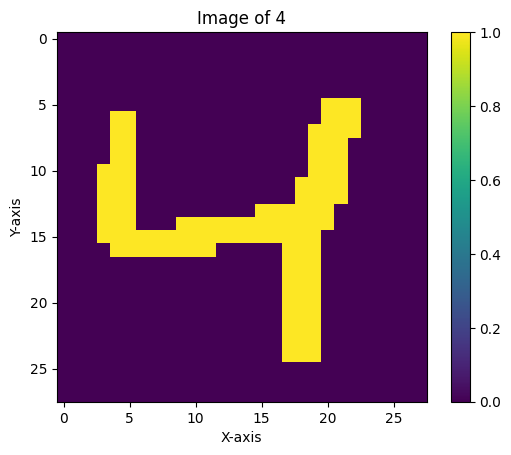

In [11]:
i = 2
plt.imshow(all_imgs_flat[i].reshape((28,28)), cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color scale
plt.title(f'Image of {all_labels[i]}')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [12]:
# 4. Convert numpy to scipy sparse arrays
sparse_imgs_flat = csr_matrix(all_imgs_flat)

In [13]:
# 5. Initialize numpy arrays data, row, column to store 2d info in sparse format

# Size of all array = upper triangle of matrix = 1+2+...69,999 =  2,449,965,000
# Memory Size of data array = 2,449,965,000 * 4 bytes (assuming 32bit float is used) = 10GB (approx)
# Memory size of row + column = 2 * 2,449,965,000 * 4 byte (assuming 32bit int is used) = 20GB (approx) [range of 16bit unsigned int is till 65k and dataset is 70k]
# total = 30gb (approx)

In [14]:
size = 2449965000
data = np.zeros(size, dtype=np.uint32)
row = np.zeros(size, dtype=np.uint32)
col = np.zeros(size, dtype=np.uint32)

In [15]:
print("Total size in bytes:", data.nbytes+row.nbytes+col.nbytes) # 29.4 GB

Total size in bytes: 29399580000


In [16]:
all_imgs_flat.shape

(70000, 784)

##Calculating euclidean distances

In [17]:
#from sklearn.metrics.pairwise import euclidean_distances

In [18]:
#distances = euclidean_distances(all_imgs_flat, all_imgs_flat)
#distances = euclidean_distances(sparse_all_imgs, sparse_all_imgs)

In [19]:
#from sklearn.utils.extmath import safe_sparse_dot

In [20]:
# def euclid_dist(x, y):
#   x_sq = safe_sparse_dot(x, x).astype(np.uint16)
#   y_sq = safe_sparse_dot(y, y).astype(np.uint16)
#   xy = safe_sparse_dot(x, y).astype(np.uint16)
#   ans = (x_sq + y_sq - 2 * xy).astype(np.uint16)
#   return  ans

In [21]:
def optimized_euclid_dist(x, y):
  result = x ^ y
  dist = np.sum(result)
  del result
  return dist.astype(np.uint16)


In [22]:
# def optimized_euclid_dist(x, y):
#   squared_diff = (x - y).power(2)
#   sum_squared_diff = squared_diff.sum()
#   return sum_squared_diff


In [25]:
subset_sz = 70000
row_sz = subset_sz * (subset_sz - 1) // 2

subset = all_imgs_flat[0:subset_sz] # For testing
subset_row = row[0:row_sz]
subset_col = col[0:row_sz]
subset_data = data[0:row_sz]

print("Total size in bytes:", subset_data.nbytes+subset_row.nbytes+subset_col.nbytes)

Total size in bytes: 29399580000


In [26]:
# Just running through the loop without any processing involved takes 22.5 min occupying 30GBs of space
data_idx = 0

for i in range(subset_sz):
  for j in range(i + 1, subset_sz):
    # subset_row[data_idx] = i
    # subset_col[data_idx] = j
    subset_data[data_idx] = optimized_euclid_dist(subset[i],subset[j])
    data_idx += 1


## PROBLEM 4: MNIST, 20 NG : Train and test KNN classification (supervised)
Your goal in this problem is to write your own K-nearest neighbor (KNN) classifier.

For each of the two datasets, now in matrix format and with pairwise similarity computed, train and test a KNN classifier. You are required to implement KNN classification model yourself, though you may use support libraries / data-structures for the neighbor searching.

You should partition the datasets into (say) an 80/10/10 training/testing/validation sets. Note that the actual "training" here consists of simply identifying nearest neighbors---unlike other common classifiers, there is no iterative or gradient-based procedure.

Report both training performance and testing performance. If using Python, you are encouraged (but not required) to write a scikit-learn compatible *estimator* class supporting a common API interface, e.g. *.fit(), *.predict(), *.transform(), etc. See https://scikit-learn.org/stable/developers/develop.html for more details.

In [42]:
def map_matrix_to_flat_idx(r,c):
  return int((r/2)*(140000+1-r) + c)

In [48]:
def eval_for_test_and_val(idx, k=10):
  heap = []
  for i in range(100): ###
    arr_idx = map_matrix_to_flat_idx(i,idx)
    curr_dist = subset_data[arr_idx]
    if len(heap) == 0:
      heap.append([curr_dist,i])
    else:
      if (heap[0][0]>curr_dist):
        heap.insert(0, [curr_dist,i])
      else:
        heap.append([curr_dist,i])
        heap.sort(key=lambda x: x[0])
      if(len(heap)>k):
        heap.pop(-1)

  # reporting most frequent label
  d = {}
  for i in range(k):
    if train_labels[heap[i][1]] in d:
      d[train_labels[heap[i][1]]] += 1
    else:
      d[train_labels[heap[i][1]]] = 1
  return max(d, key=d.get)


In [44]:
def eval_for_train(idx, k=10):
  heap = []
  for i in range(idx+1,100): ###
    arr_idx = map_matrix_to_flat_idx(idx,i)
    #print(arr_idx)
    curr_dist = subset_data[arr_idx]
    if len(heap) == 0:
      heap.append([curr_dist,i])
    else:
      if (heap[0][0]>curr_dist):
        heap.insert(0, [curr_dist,i])
      else:
        heap.append([curr_dist,i])
        heap.sort(key=lambda x: x[0])
      if(len(heap)>k):
        heap.pop(-1)

  for i in range(idx): ###
    arr_idx = map_matrix_to_flat_idx(i,idx)
    curr_dist = subset_data[arr_idx]
    if len(heap) == 0:
      heap.append([curr_dist,i])
    else:
      if (heap[0][0]>curr_dist):
        heap.insert(0, [curr_dist,i])
      else:
        heap.append([curr_dist,i])
        heap.sort(key=lambda x: x[0])
      if(len(heap)>k):
        heap.pop(-1)

  # reporting most frequent label
  d = {}
  for i in range(k):
    if train_labels[heap[i][1]] in d:
      d[train_labels[heap[i][1]]] += 1
    else:
      d[train_labels[heap[i][1]]] = 1
  return max(d, key=d.get)


In [47]:
# Evaluating train
correct = 0
for i in range(100): ####
  if(eval_for_train(i) == all_labels[i]):
    correct += 1
print(f'Training Accuracy: {(correct/100)*100}') ####

Training Accuracy: 12.0


In [45]:
# Evaluating Validation
correct = 0
for i in range(56000,56100): ####
  if(eval_for_test_and_val(i) == all_labels[i]):
    correct += 1
print(f'Validation Accuracy: {(correct/100)*100}') ####

Validation Accuracy: 18.0


In [46]:
# Evaluating Validation
correct = 0
for i in range(63000,63100): ####
  if(eval_for_test_and_val(i) == all_labels[i]):
    correct += 1
print(f'Validation Accuracy: {(correct/100)*100}') ####

Validation Accuracy: 13.0
